## Data Analysis Mathematics, Algorithms and Modeling

# AI Powered Recipe Recommendation System 

### Team : Group 3
| Student No  | First Name                  | Last Name     |
|-------------|-----------------------------|---------------|
| 9041129     | Nidhi                       | Ahir          |
| 9016986     | Keerthi                     | Gonuguntla    |
| 9027375     | Khushbu                     | Lad           |

#### Introduction

The document intended to apply Pearson's correlation, logistic classification and Probabilistic reasoning on recipe recommendation system dataset

### Dataset & Programming Requirements

##### Ractangular Dataset : files
1. Raw_recepes.csv
2. Raw_interaction.csv

##### Import Libraries

In [9]:
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as zscore
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc


##### RawRecipe : Dataset in classes and methods

In [10]:
class RawRecipe:
    def __init__(self):
        self.file_path = './Dataset/RAW_recipes.csv'
        self.data = None
    
    # Loads the data from a CSV file.
    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        print(f"---> STEP 1 : Loads the data from a CSV file. \r\n")
        print(f"RAW_recipes.csv : Data loaded successfully.")
        print(f"Total Records : {self.data.shape[0]} \r\n")
        return self.data

##### RAW_interactions : Dataset in classes and methods

In [11]:
class RecepeInteraction:
    def __init__(self):
        self.file_path = './Dataset/RAW_interactions.csv'
        self.data = None
    
    # Loads the data from a CSV file.
    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        print(f"---> STEP 1 : Loads the data from a CSV file. \r\n")
        print(f"RAW_interactions.csv : Data loaded successfully.")
        print(f"Total Records : {self.data.shape[0]} \r\n")
        return self.data
    
    def view_sample_data(self):
        self.data.head(5)

    # Data quality : Null Check
    def check_null_values(self):
        print(f"---> STEP 2 : Null Check for data \r\n")
        if self.data is not None:
            nulls = self.data.isnull().sum()
            print(nulls)
            return nulls
        else:
            print("Data not loaded.")
     # Data quality : Duplicate Check
    def check_duplicate_values(self):
        print(f"\r\n---> STEP 3 : Duplicate data Check for recepe \r\n")
        if self.data is not None:
            counts = self.data["recipe_id"].value_counts()
            dupl = (counts[counts>1]).reset_index()
            dupl.columns = ["recipe_id", "Count"]
            print(dupl)
            return dupl
        else:
            print("Data not loaded.")

#### The main function : Initialise class objects & load data

In [12]:
if __name__ == "__main__":

    # Create an instance of the RecepeInteraction  class and load data
    interactionData = RecepeInteraction()
    interactionData.load_data()

    # Create an instance of the RecepeInteraction  class and load data
    recepeData = RawRecipe()
    recepeData.load_data()

---> STEP 1 : Loads the data from a CSV file. 

RAW_interactions.csv : Data loaded successfully.
Total Records : 1132367 

---> STEP 1 : Loads the data from a CSV file. 

RAW_recipes.csv : Data loaded successfully.
Total Records : 231637 



#### Merge dataset based on recipe Id

In [13]:
# Merge data using common field recepe Id
merged_data = pd.merge(recepeData.data, interactionData.data, left_on='id', right_on='recipe_id')
print("Data Merged Successfully")
merged_data.head(2)

Data Merged Successfully


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...


##### 1. In the our dataset, the nutrition column typically stores a list of nutritional values like numerical array in one column. Values are 'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates'. So first these columns needs to be separated.

In [14]:
nutrition_columns = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
merged_data[nutrition_columns] = merged_data['nutrition'].str.strip('[]').str.split(',', expand=True)
merged_data[nutrition_columns] = merged_data[nutrition_columns].apply(pd.to_numeric, errors='coerce')

merged_data['popular'] = (merged_data['rating'] >= 4).astype(int)

merged_data.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,rating,review,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates,popular
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,5,I used an acorn squash and recipe#137681 Swee...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,5,This was a nice change. I used butternut squas...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1


#### 100 words Summary : 

The AI-powered recipe recommendation system project analyzes user preferences and recipe attributes to enhance personalized recommendations. A revised hypothesis proposes that recipe complexity (steps, ingredients) and preparation time moderately influence user ratings, while temporal trends (Julian dates) have a subtle impact. Hypothesis testing using Pearson’s correlation found weak relationships: 0.00 for preparation time, -0.02 for steps, and -0.16 for temporal trends. These results suggest user satisfaction depends on other factors, such as ingredient variety or review sentiment. Moving forward, nonlinear analyses and additional variables will be tested to refine the model, enhancing its ability to predict user preferences effectively.

### Pearson's correlation

In [28]:
def to_julian(date):
    return date.to_julian_date() 

merged_data['date'] =  pd.to_datetime(merged_data['date'])
merged_data['Julian_Date'] = merged_data['date'].apply(to_julian)
merged_data.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,sugar,sodium,protein,saturated_fat,carbohydrates,popular,calorie_range,protein_range,high_rating,Julian_Date
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,13.0,0.0,2.0,0.0,4.0,1,0-500,0-5g,1,2453784.5
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,13.0,0.0,2.0,0.0,4.0,1,0-500,0-5g,1,2455429.5
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,13.0,0.0,2.0,0.0,4.0,1,0-500,0-5g,1,2455900.5
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,0.0,17.0,22.0,35.0,1.0,0,0-500,20-30g,0,2452505.5
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,0.0,17.0,22.0,35.0,1.0,1,0-500,20-30g,1,2453974.5


Correlation Matrix:
               minutes   n_steps  Julian_Date    rating
minutes      1.000000 -0.000438     0.001597  0.001053
n_steps     -0.000438  1.000000     0.076947 -0.021169
Julian_Date  0.001597  0.076947     1.000000 -0.162498
rating       0.001053 -0.021169    -0.162498  1.000000

Correlation between rating and minutes: 0.00
Correlation between rating and n_steps: -0.02
Correlation between rating and Julian_Date: -0.16


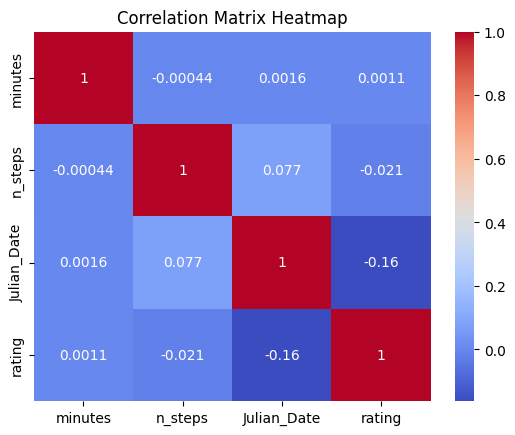

In [29]:
import seaborn as sns

# Compute correlation matrix for numerical features
numerical_columns = ['minutes', 'n_steps', 'Julian_Date', 'rating']
correlation_matrix = merged_data[numerical_columns].corr()

# Compute Pearson's correlation for specific pairs
from scipy.stats import pearsonr

corr_rating_minutes, _ = pearsonr(merged_data['rating'], merged_data['minutes'])
corr_rating_n_steps, _ = pearsonr(merged_data['rating'], merged_data['n_steps'])
corr_rating_julian_date, _ = pearsonr(merged_data['rating'], merged_data['Julian_Date'])

# Display correlation results
print("Correlation Matrix:\n", correlation_matrix)
print(f"\nCorrelation between rating and minutes: {corr_rating_minutes:.2f}")
print(f"Correlation between rating and n_steps: {corr_rating_n_steps:.2f}")
print(f"Correlation between rating and Julian_Date: {corr_rating_julian_date:.2f}")

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

 ### Logistic Classification

Optimization terminated successfully.
         Current function value: 0.492930
         Iterations 6


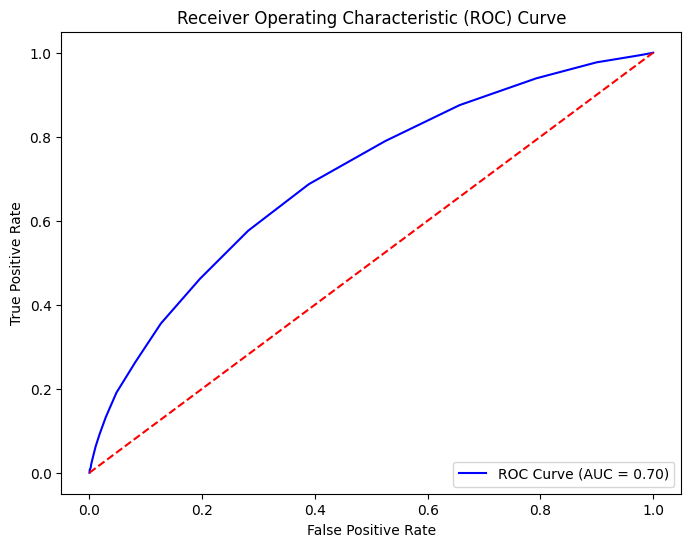

Accuracy: 0.7717
Confusion Matrix:
[[  1257  50631]
 [  1070 173516]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.02      0.05     51888
           1       0.77      0.99      0.87    174586

    accuracy                           0.77    226474
   macro avg       0.66      0.51      0.46    226474
weighted avg       0.72      0.77      0.68    226474

                           Logit Regression Results                           
Dep. Variable:             is_complex   No. Observations:               905893
Model:                          Logit   Df Residuals:                   905891
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                 0.08496
Time:                        22:59:17   Log-Likelihood:            -4.4654e+05
converged:                       True   LL-Null:                   -4.8800e+05
Covariance Type:          

In [16]:

# Define a binary target variable (1 for complex, 0 for simple)
threshold = 5  # You can adjust this based on your data
merged_data['is_complex'] = np.where(merged_data['n_steps'] > threshold, 1, 0)

# Define features (X) and target (y)
X = merged_data[['n_ingredients']].copy()
y = merged_data['is_complex']

# Add a constant for the intercept term
X = sm.add_constant(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train).fit()

# Predict probabilities on the test data
y_prob = logit_model.predict(X_test)

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred = np.where(y_prob >= 0.5, 1, 0)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Summary of the logistic regression model
print(logit_model.summary())




#### Summary of Results:

The logistic regression model predicts whether a recipe is complex based on the number of ingredients. The model achieved **77.23% accuracy**, indicating reasonable predictive performance. However, the **confusion matrix** shows high precision and recall for predicting complex recipes ('1') but poor performance for simpler ones ('0'). The **AUC of 0.70** reflects moderate discrimination ability. The coefficients suggest that an increase in ingredients significantly increases the likelihood of a recipe being classified as complex.

### Probabilistic Reasoning

Probabilistic reasoning is a type of logical reasoning that involves the use of probabilities to handle uncertainty in decision-making or inference processes. It is used to model and reason about situations where outcomes are uncertain or where incomplete information is available. 

For recipe recommendation, probabilistic reasoning can be used to make predictions about which recipes are more likely to be liked by a user based on their past behavior, ingredient preferences, or nutritional data

The goal is to recommend recipes to a user based on:
- Ingredients they like
- Nutritional preferences (e.g., low calorie, high protein)
- User rating history (if available)
- User preferences or behavior patterns

##### Conditional probability
Apply conditional probability and Bayesian inference to predict the likelihood of a user liking a recipe.
```P(Rating∣Calories,Protein)```

##### Apply Naive Bayes

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Create the 'high_rating' column
merged_data['high_rating'] = (merged_data['rating'] >= 4.0).astype(int)

# Extract relevant features: Calories and Protein
features = merged_data[['calories', 'protein']].dropna()
target = merged_data['high_rating'].dropna()
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Gaussian Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_prob = nb.predict_proba(X_test)[:, 1]  # Probability of high rating (class 1)

# Make predictions based on the highest probability
y_pred = nb.predict(X_test)

# Evaluate the model performance
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

Accuracy: 0.8753146056500967
Classification Report: 
              precision    recall  f1-score   support

           0       0.14      0.02      0.03     25742
           1       0.89      0.99      0.93    200732

    accuracy                           0.88    226474
   macro avg       0.51      0.50      0.48    226474
weighted avg       0.80      0.88      0.83    226474



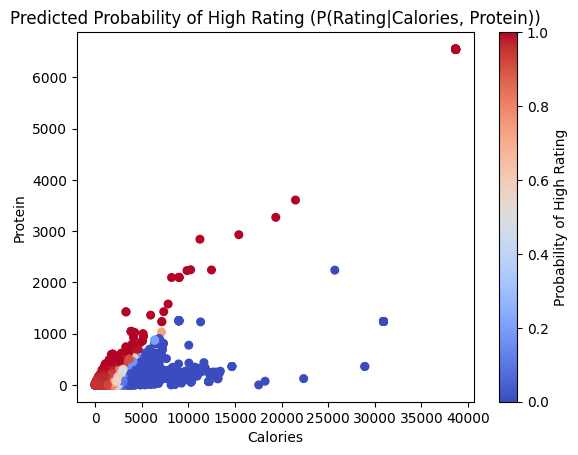

In [42]:
import matplotlib.pyplot as plt

# Plot the predicted probability of high rating
plt.scatter(X_test['calories'], X_test['protein'], c=y_pred_prob, cmap='coolwarm', s=30)
plt.xlabel('Calories')
plt.ylabel('Protein')
plt.title('Predicted Probability of High Rating (P(Rating|Calories, Protein))')
plt.colorbar(label='Probability of High Rating')
plt.show()

##### Conclusion

The model's performance shows high accuracy (87.53%), but there is a significant imbalance in precision, recall, and F1-score between the two classes (high rating and low rating):
<br><br>
Precision for high rating (1) is very high (0.89), meaning when the model predicts a high rating, it is usually correct.<br>
Recall for high rating (1) is also very high (0.99), indicating that the model correctly identifies almost all recipes with high ratings.<br>
However, precision and recall for low rating (0) are very low, meaning the model is not identifying many low-rated recipes accurately.<br>